# NVIDIA Nsight Systems
[NVIDIA Nsight™ Systems](https://developer.nvidia.com/nsight-systems) is a system-wide performance analysis tool designed to visualize an application’s algorithms, help to identify the largest opportunities to optimize, and tune to scale efficiently across any quantity or size of CPUs and GPUs.

# NVIDIA Tools Extension (NVTX)
The [NVIDIA® Tools Extension Library (NVTX)](https://github.com/NVIDIA/NVTX) is a powerful mechanism that allows users to manually instrument their application. With a C-based and a python-based Application Programming Interface (API) for annotating events, code ranges, and resources in your applications. Applications which integrate NVTX can use NVIDIA Nsight, Tegra System Profiler, and Visual Profiler to capture and visualize these events and ranges. In general, the NVTX can bring valuable insignt into the application while incurring almost no overhead. 

# MONAI Training Pipeline and NVTX
[MONAI](https://github.com/Project-MONAI/MONAI) is a high level framework for deep learning in healthcare imaging. 

For performance profiling, we mainly focus on two fronts: data loading/transforms, and training/validation iterations.

[Transforms](https://github.com/Project-MONAI/MONAI/tree/dev/monai/transforms) is one core concept of data handling in MONAI, similar to [TorchVision Transfoms] (https://pytorch.org/vision/stable/transforms.html). Several of these transfoms are usually chained together, using a [Compose](https://github.com/Project-MONAI/MONAI/blob/2f1c7a5d1b47c8dd21681dbe1b67213aa3278cd7/monai/transforms/compose.py#L35) class, to create a preprocessing or postprocessing pipeline that performs manipulation of the input data and make it suitable for training a deep learning model or inference. To dig into the cost from each individual transform, we enable the insertion of NVTX annotations via [MONAI NVTX Tranforms]().

For training and validation steps, they are easier to track by setting NVTX annotations within the loop.

# Profiling Spleen Segmentation Pipeline
## Environment Setup
Install packages and download dataset.

In [ ]:
!pip install git+https://github.com/Project-MONAI/MONAI
!pip install pytorch-ignite
!pip install nibabel
!pip install tqdm
!pip install -q "nvidia-pyindex"
!pip install -q "nvidia-dlprof[pytorch]"
!pip install -q "nvtx"

## Run Nsight Profiling 
We run DLprof (v1.4.0 / r21.08) on the trainer under basic settings for 6 epochs, with validation every 2 epochs.

In [ ]:
!dlprof --mode pytorch \
        --reports=summary \
        --formats json \
        --output_path ./outputs_base \
        python3 train_base_nvtx.py 

# Identify Potential Performance Improvements 
## Profile Results
After profiling, DLProf provides summary regarding the training process. Also, the computing details can be visualized via Nsight System GUI. (The version of Nsight used in the tutorial is 2021.3.1.54-ee9c30a OSX)

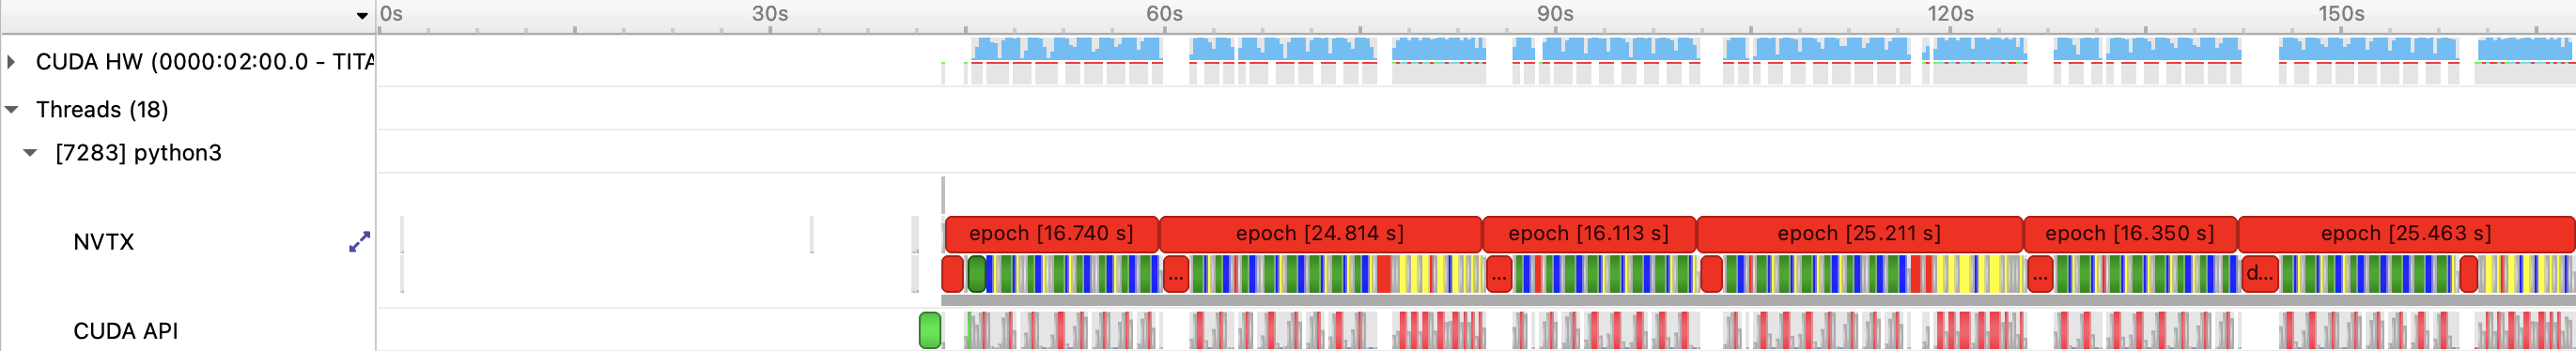

In [2]:
from IPython.display import display, Image
display(Image(filename="Figure/nsight_base.png", width=800))

## Observations
As can be observed from the Nsight GUI, clear patterns can be found:
- 6 epochs' training:
  - Epochs 1/3/5 withour validation;
  - Epoch 2/4/6 with validation;
- Clear data loading/IO gaps between epochs.

It can be noticed from the profiling result that:
- CacheDataset would load all training images into CPU RAM (the initial ~40 sec.);
- Between epochs of training/validation, there are considerable amount of time cost for data loading (red);
- Between steps/iterations of training/validation, the time of data loading is much smaller (red);
- The GPU utilization (CUDA HW) is decent during each training/validation step (green/blue/yellow);

Upon further analysis of convergence, it appears that the convergence is relatively slow. Therefore, there are two directions of performance improvement:
- Per-epoch time reduction: by utilizing pre-indexing and thread-based dataloader;
- Faster convergence: by utilizing different optimizers and loss functions.

One optimized solution can be found here (https://github.com/Project-MONAI/tutorials/blob/master/acceleration/fast_training_tutorial.ipynb). Then we add the corresponding tensorboard figure. Based on the validation accuracy curves, we can observe that the optimized solution has much better convergence. And the GPU utilization rate is above 90% on average.

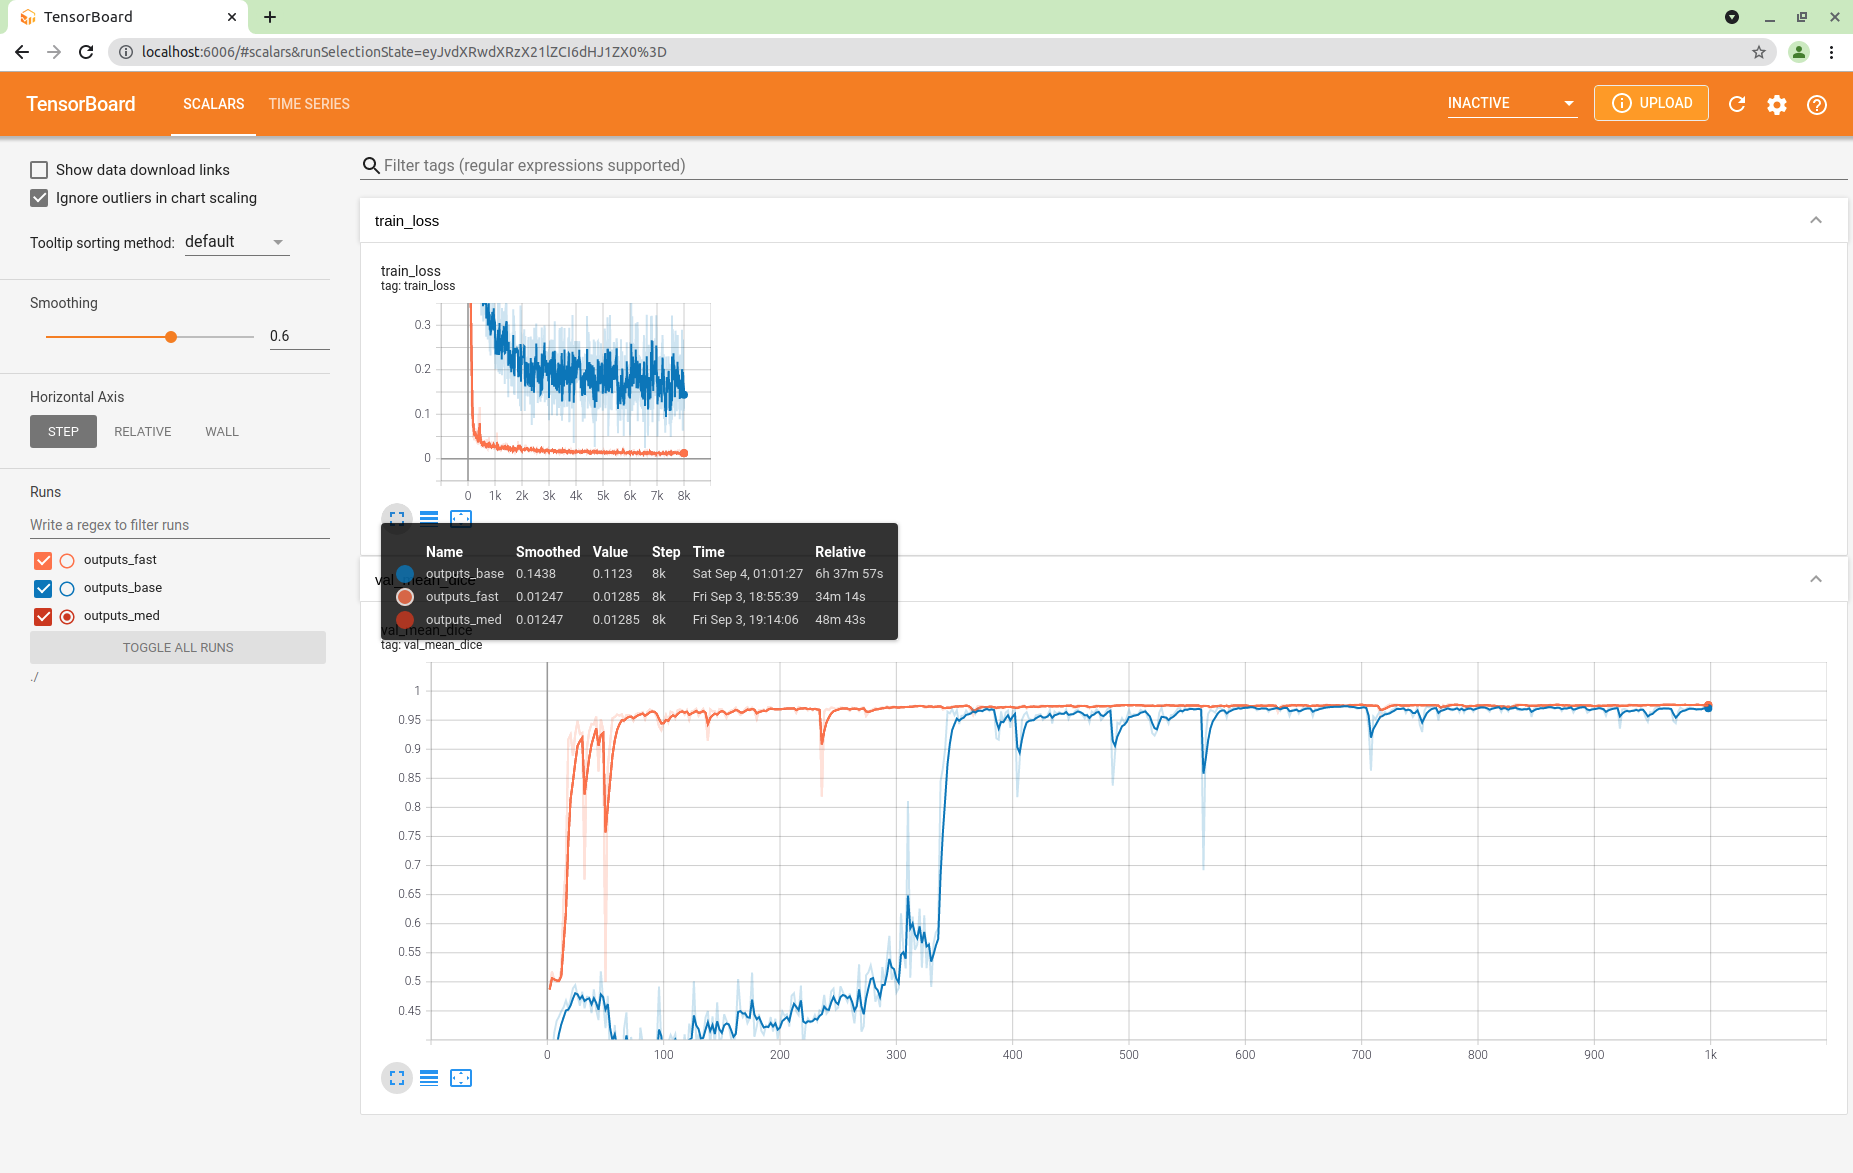

In [4]:
display(Image(filename="Figure/tensorboard.png", width=800))

# Analyzing Performance Improvement
## Profile Results
We again use DLProf to further analyze the optimized training script.

In [ ]:
!dlprof --mode pytorch \
        --reports=summary \
        --formats json \
        --output_path ./outputs_fast \
        python3 train_fast_nvtx.py 

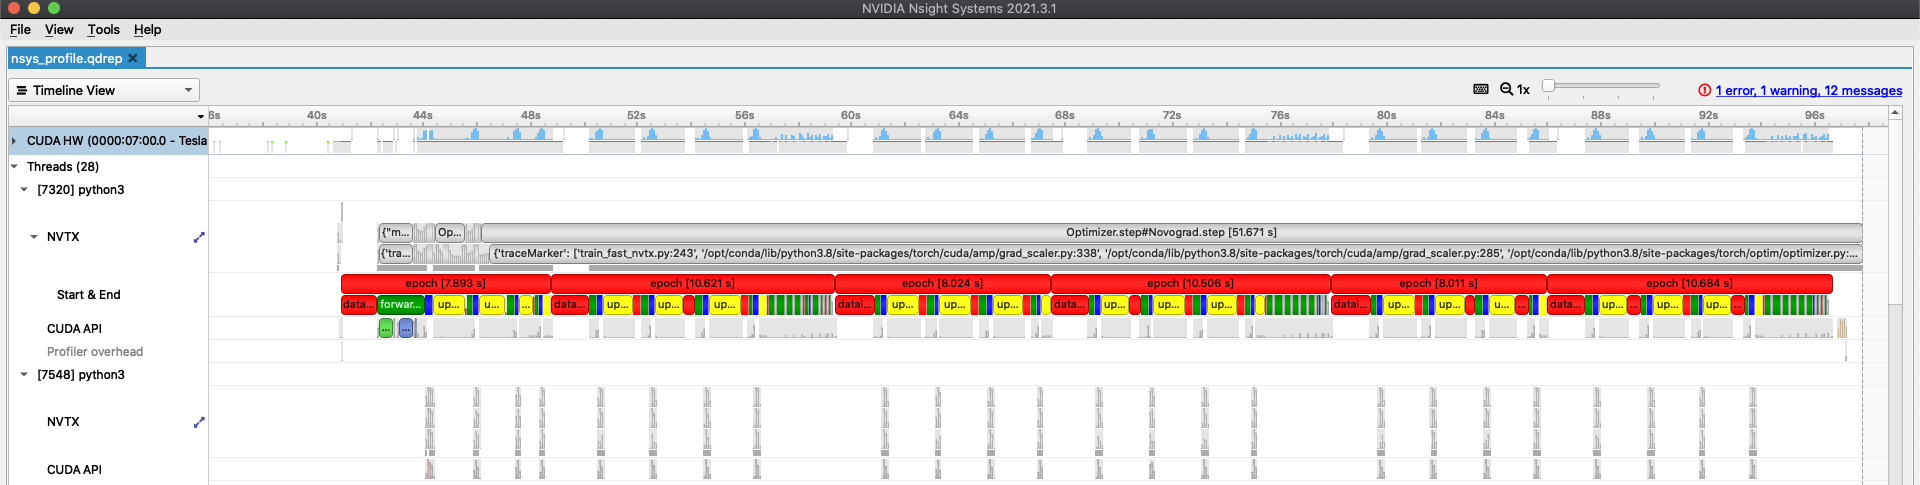

In [11]:
display(Image(filename="Figure/nsight_fast.png", width=800))

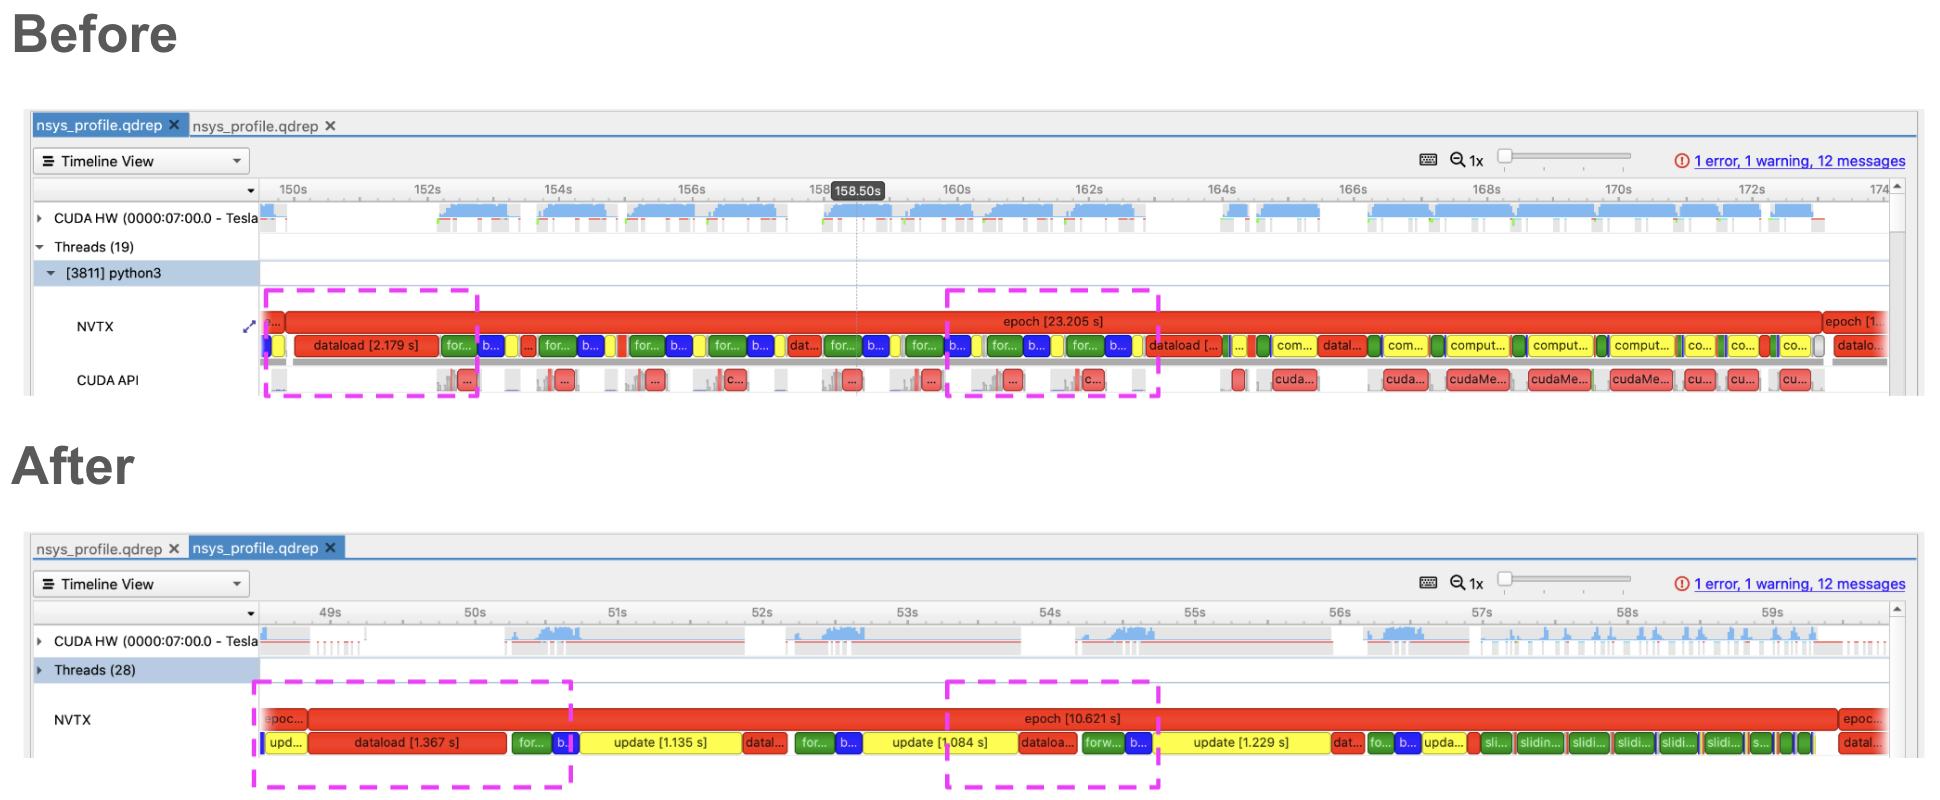

In [4]:
display(Image(filename="Figure/nsight_comparison.png", width=800))

As shown in the figure, the optimized solution uses much less time for data I/O (marked in the boxes), and the percentage of computing time for other GPU based operations (e.g., model optimization, foreward/backward operations, sliding-window inference, etc.) has been further increased. Therefore, the computing efficiency and GPU utilization for a single epoch and the overall training process can be improved by a large margin.

Moreover, another profiling example for pathological image analysis can be found in the following [link](https://github.com/Project-MONAI/tutorials/blob/master/pathology/tumor_detection/ignite/profiling_camelyon_pipeline.ipynb).